Shows ground truth comparisons with red vs. green boxes for a given IoU threshold


requires pytorch_annotations_cropped.csv (not included on GitHub contact repo owner)

In [12]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from dataset import CustomDataset
import numpy as np
import torchvision
import matplotlib.patches as patches
import random
from matplotlib.animation import FuncAnimation
%matplotlib widget
# Loading model and dataset

def get_model_instance_segmentation(num_classes):
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

def get_transform(train):
    transforms = []
    if train:
        pass
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = fasterrcnn_resnet50_fpn(weights="DEFAULT", box_detections_per_img=400)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model.load_state_dict(torch.load('/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth', map_location=device))
model.to(device).eval()

print('model loaded')

annotations_file = "/home/rohit/AIXI/model1_8/1_8_pytorch_annotations_cropped.csv" 
image_dir = "/home/rohit/AIXI/annotated_images_flat_cropped/"
dataset = CustomDataset(annotations_file, image_dir, get_transform(train=False))

print('dataset loaded')
print(len(dataset))

eval_transform = get_transform(train=False)

# Functions for predicting and plotting boxes - not used


def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def plot_predicted_boxes_with_iou(ax, pred_boxes, gt_boxes, labels=None, iou_threshold=0.3):
    # Keep track of which predictions have been matched to a ground truth
    matched = [False] * len(pred_boxes)

    for i, pred_box in enumerate(pred_boxes):
        # Default color for incorrect predictions
        color = 'red'
        for gt_box in gt_boxes:
            iou = calculate_iou(pred_box, gt_box)
            if iou >= iou_threshold:
                # Correct prediction
                color = 'green'
                matched[i] = True
                break
        
        # Draw the prediction box
        x, y, x2, y2 = pred_box
        rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        if labels:
            ax.text(x, y, labels[i], va='bottom', ha='left', color=color, fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor=color))

model loaded
dataset loaded
9904


In [13]:


def update(frame_idx, show_labels=False):
    filename = frame_files[frame_idx]
    # Clear previous frame
    axes[0].clear()
    axes[1].clear()

    image_path = os.path.join(image_dir, filename)
    image = read_image(image_path)

    # Get annotations
    img_target = dataset.get_item_by_filename(filename)
    if img_target is None:
        print(f"Skipping {filename} due to missing annotations.")
        return
    
    img, target = img_target

    if img is None or target is None:
        print(f"Skipping {filename} due to missing data.")
        return  # Again, ensure no further processing for this frame

    # Convert the image from PyTorch tensor to numpy array and clip the data
    img_np = img.permute(1, 2, 0).cpu().numpy()  # Move tensor to CPU and convert to numpy
    img_np = np.clip(img_np, 0, 1)

    # Get model predictions
    model.eval()
    with torch.no_grad():
        x = eval_transform(image)
        x = x[:3, ...].to(device)
        predictions = model([x, ])
        pred = predictions[0]

    # Filter predictions based on the confidence score
    high_conf_indices = [i for i, score in enumerate(pred['scores']) if score > confidence_threshold]
    high_conf_boxes = pred['boxes'][high_conf_indices].long()
    if show_labels:
        high_conf_labels = [f"grain: {score:.3f}" for score in pred['scores'][high_conf_indices]]
    else:
        high_conf_labels = [''] * len(high_conf_indices)  # Empty labels if show_labels is False

    # Plot annotations on axes[0]
    axes[0].imshow(img_np, cmap='gray')
    boxes = target['boxes'].cpu().numpy()  # Move tensor to CPU and convert to numpy
    gt_boxes_np = target['boxes'].cpu().numpy() 
    for box in boxes:
        x, y, x2, y2 = box
        rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2, edgecolor='b', facecolor='none')
        axes[0].add_patch(rect)

    # Plot predictions on axes[1]
    high_conf_boxes = high_conf_boxes.cpu().numpy()  # Move tensor to CPU and convert to numpy
    axes[1].imshow(img_np, cmap='gray')
    plot_predicted_boxes_with_iou(axes[1], high_conf_boxes, gt_boxes_np, high_conf_labels, iou_threshold=0.5)

    # Set titles for subplots
    axes[0].set_title(f'Annotations - {filename}')
    axes[1].set_title(f'Predictions - {filename}')


Number of frames: 37


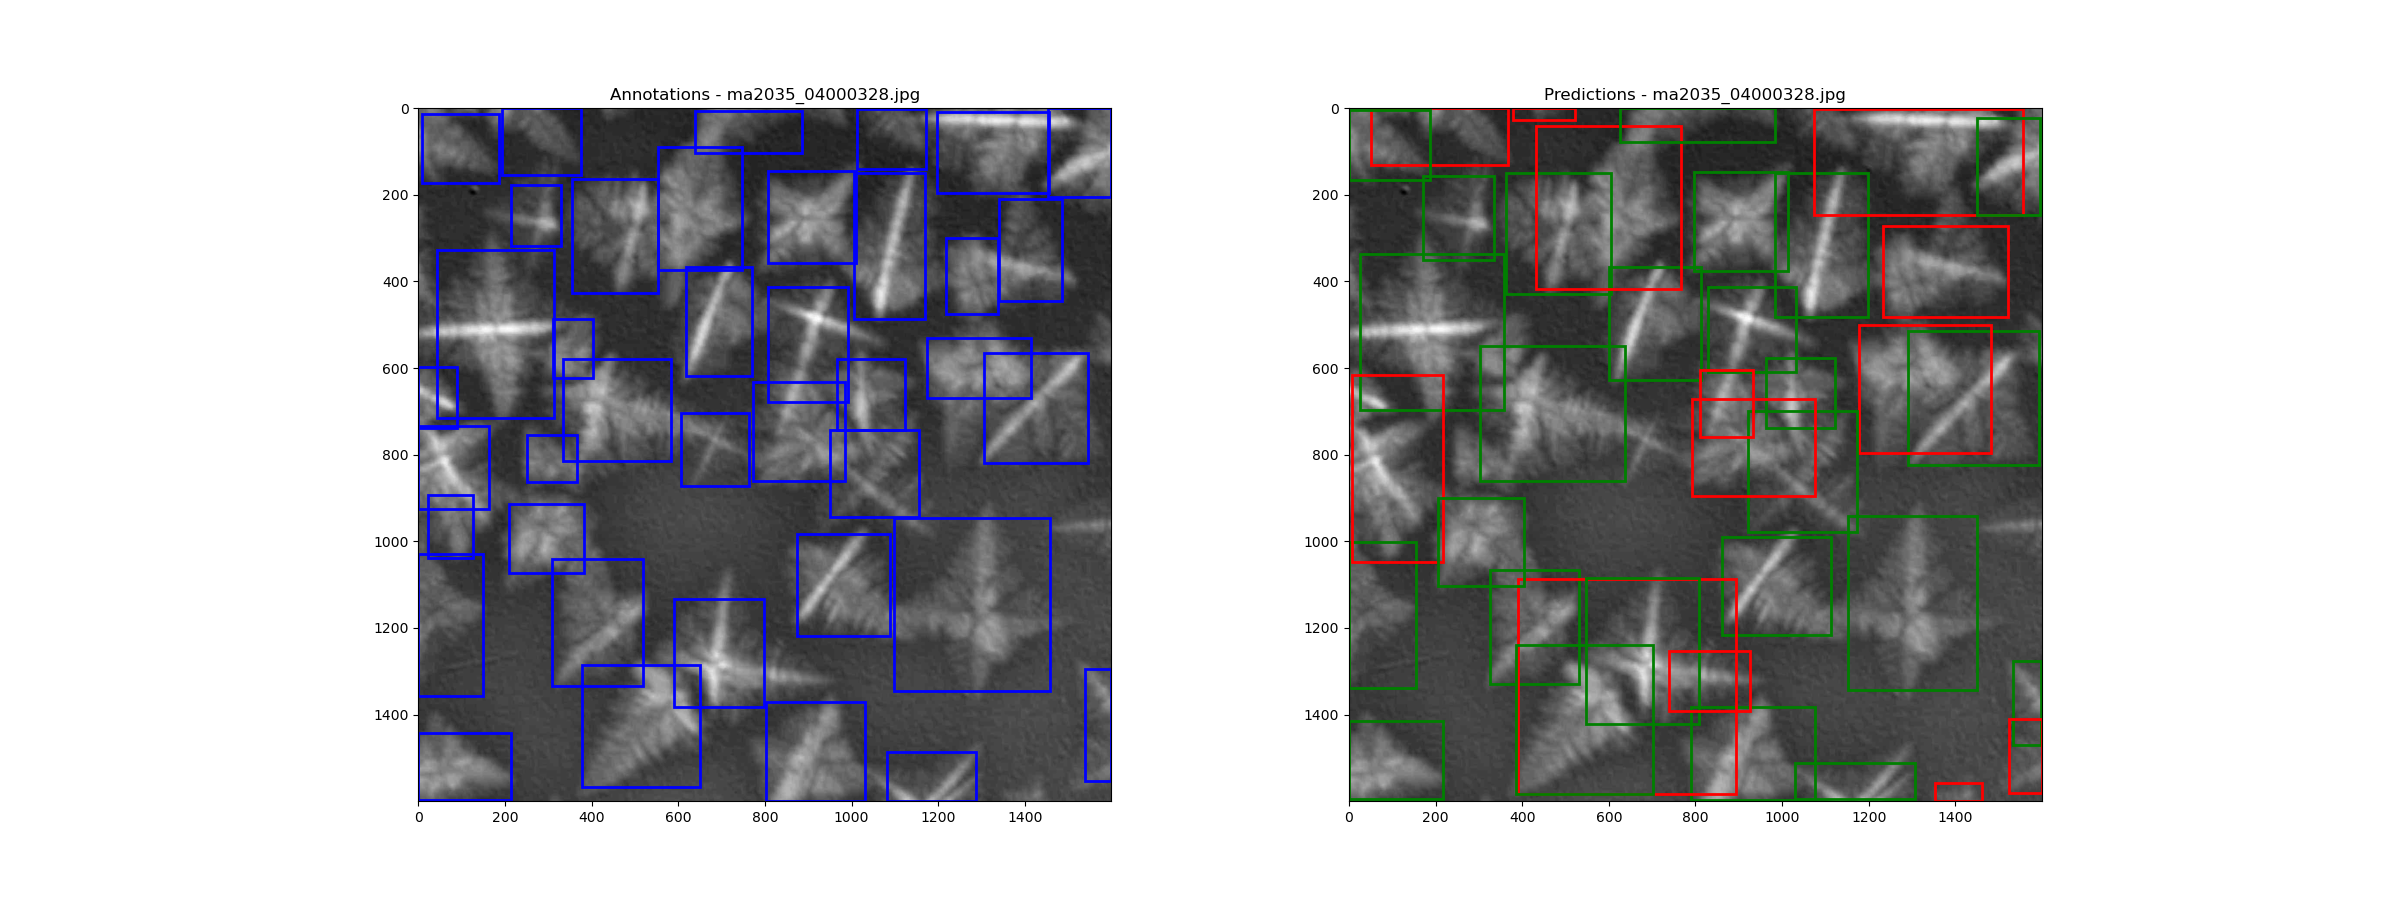

In [14]:
experiment_nums = ['040']


for i in experiment_nums:
    experiment_num = i
    confidence_threshold = 0.35

    frame_files = []
    for filename in os.listdir(image_dir):
        if filename.startswith(f'ma2035_{experiment_num}') and filename.lower().endswith('.jpg'):
            frame_files.append(filename)

    frame_files = sorted(frame_files)
    print(f"Number of frames: {len(frame_files)}")

    fig, axes = plt.subplots(1, 2, figsize=(24, 9))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.001, hspace=None)

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(frame_files), repeat=False)

    # Save the animation
    ani.save(f'experiment_thesis_test_{experiment_num}.mp4', writer='ffmpeg', fps=15)